In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

In [47]:
data_dir = '/home/roy/neural/box'


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(299),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=3, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=3, shuffle=True)

classes = ['blue', 'green', 'red']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


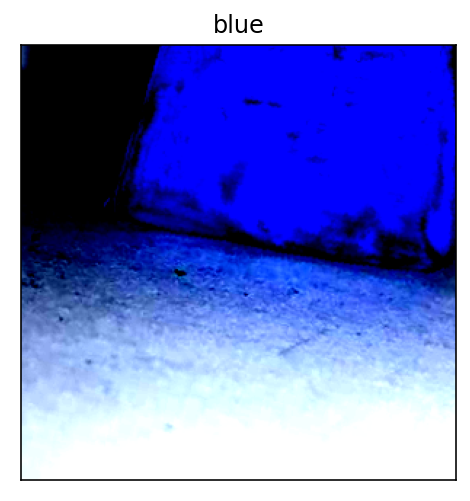

In [48]:

dataiter = iter(trainloader)
images, labels = dataiter.next()

images = images.numpy() 

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1,1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [20]:
model = models.inception_v3(pretrained=True)
model.aux_logits=False # set to false in train mode
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [49]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



for param in model.parameters():
    param.requires_grad = False
    


#last_layer = nn.Linear(n_inputs, len(classes))
last_layer = nn.Sequential(nn.Linear(2048, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                           nn.Linear(256, 100),
                                nn.ReLU(),
                               nn.Dropout(0.2),
                                 nn.Linear(100, 3),
                                 nn.LogSoftmax(dim=1))
model.fc = last_layer

#print(model.classifier[4].out_features)
print(model)

criterion = nn.NLLLoss()


optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [54]:
import time
epochs = 20
steps = 0
running_loss = 0
train_losses, test_losses,accuracy_acc = [], [],[]
start = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model(inputs)
                batch_loss = criterion(logps, labels)
                    
                test_loss += batch_loss.item()
                    
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracy_acc.append(accuracy/len(testloader))
                    
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        running_loss = 0
        model.train()
print("Time required: "+str(time.time() - start)+" seconds")

Epoch: 1/20..  Training Loss: 0.812..  Test Loss: 0.660..  Test Accuracy: 0.598
Epoch: 2/20..  Training Loss: 0.692..  Test Loss: 0.655..  Test Accuracy: 0.659
Epoch: 3/20..  Training Loss: 0.913..  Test Loss: 0.679..  Test Accuracy: 0.826
Epoch: 4/20..  Training Loss: 0.752..  Test Loss: 0.710..  Test Accuracy: 0.561
Epoch: 5/20..  Training Loss: 0.680..  Test Loss: 0.662..  Test Accuracy: 0.750
Epoch: 6/20..  Training Loss: 0.969..  Test Loss: 0.712..  Test Accuracy: 0.773
Epoch: 7/20..  Training Loss: 0.881..  Test Loss: 0.622..  Test Accuracy: 0.818
Epoch: 8/20..  Training Loss: 0.841..  Test Loss: 0.726..  Test Accuracy: 0.621
Epoch: 9/20..  Training Loss: 0.844..  Test Loss: 0.588..  Test Accuracy: 0.750
Epoch: 10/20..  Training Loss: 0.858..  Test Loss: 0.648..  Test Accuracy: 0.765
Epoch: 11/20..  Training Loss: 0.783..  Test Loss: 0.655..  Test Accuracy: 0.765
Epoch: 12/20..  Training Loss: 0.811..  Test Loss: 0.593..  Test Accuracy: 0.803
Epoch: 13/20..  Training Loss: 0.788.

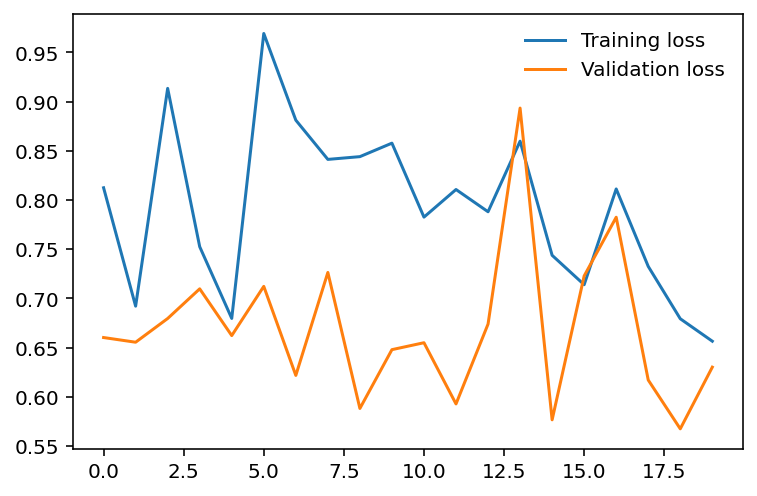

In [55]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

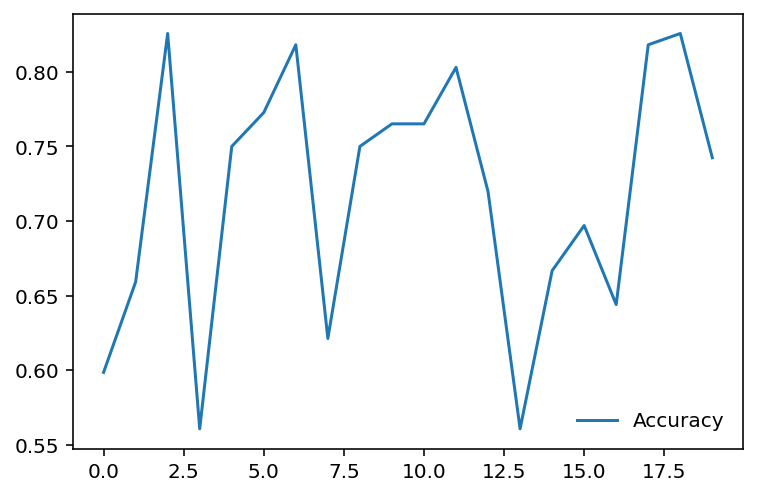

In [56]:
plt.plot(accuracy_acc, label='Accuracy')
plt.legend(frameon=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-2.0025, -1.8875, -0.3375]], grad_fn=<LogSoftmaxBackward>)
tensor([2])
2
Prediciton red
True class blue


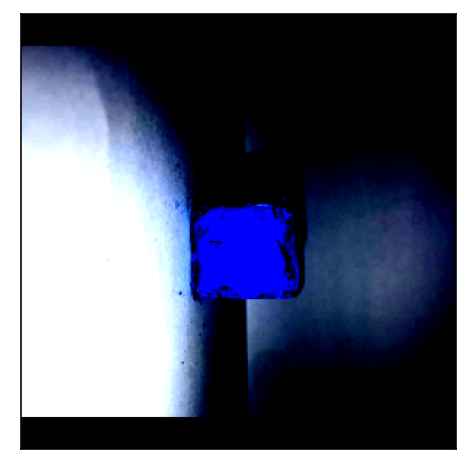

In [58]:

testloader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True)

dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    images = images.cuda()


output = model(images)
print(output)
_, preds_tensor = torch.max(output, 1)
print(preds_tensor)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

print(preds)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1, 1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    print("Prediciton "+classes[preds])
    print("True class "+classes[labels])
    